In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from nnpcg import EasyTrainer

In [2]:
# Prepare the dataset
training_data_folder = '/home/dpastor/Dropbox (Biocomputing)/GitHub/projects/nnpcg/nnpcg/data/training_data'
tt = EasyTrainer(pdb_file=os.path.join(training_data_folder, 'chignolin_cln025.pdb'), psf_file=os.path.join(training_data_folder, 'chignolin_ca_top.psf'), coords_array=os.path.join(training_data_folder, 'chignolin_ca_coords.npy'))

2023-04-13 10:25:38,657 - moleculekit.molecule - INFO - Removed 83 atoms. 10 atoms remaining in the molecule.


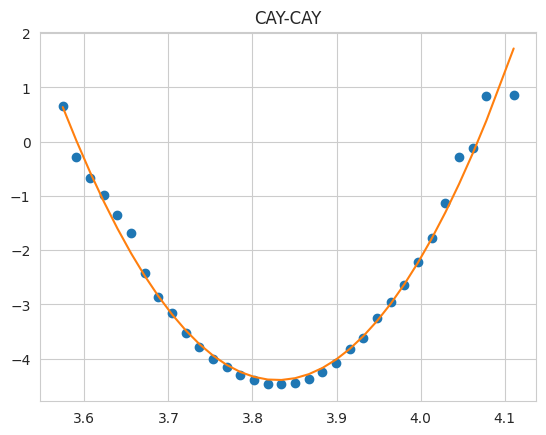

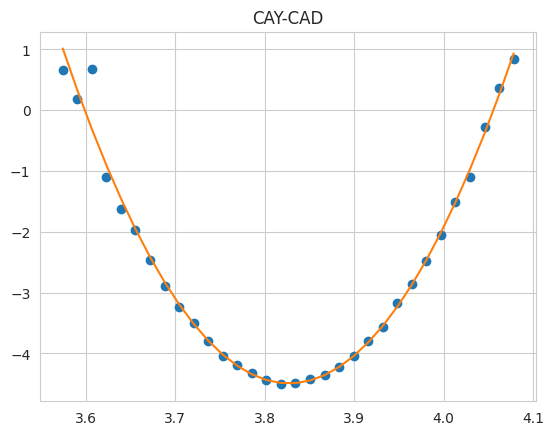

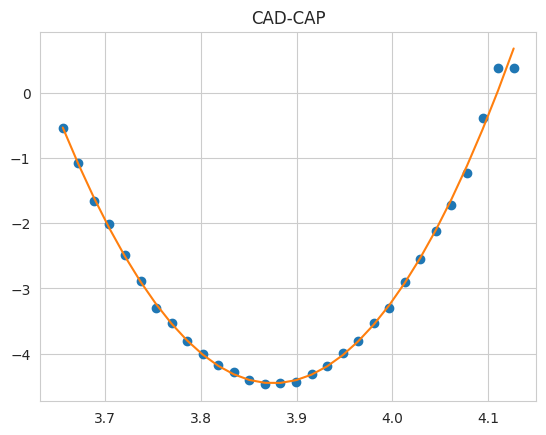

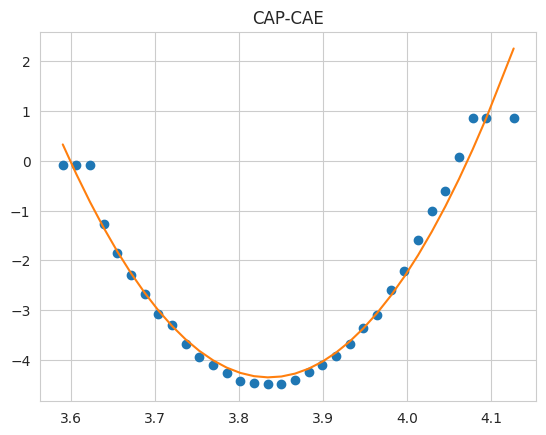

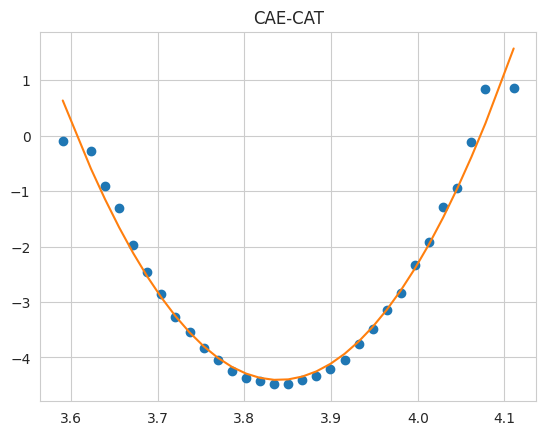

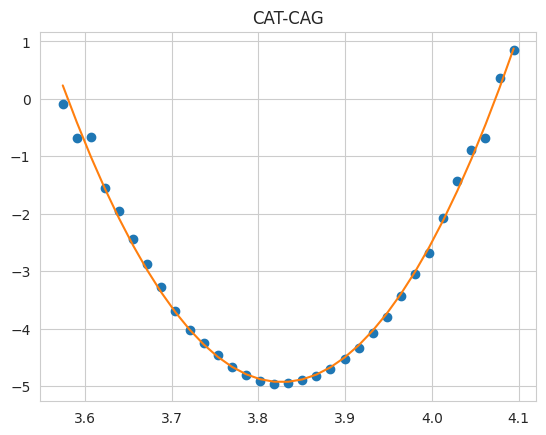

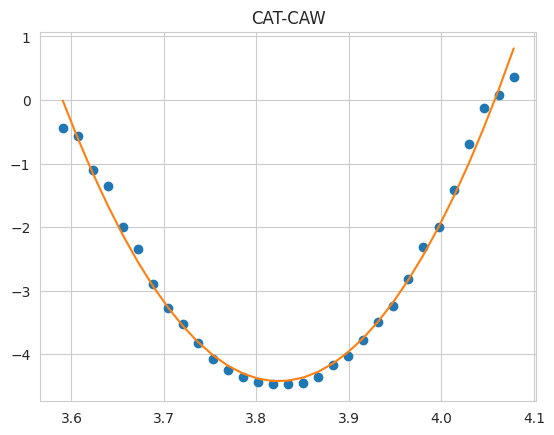

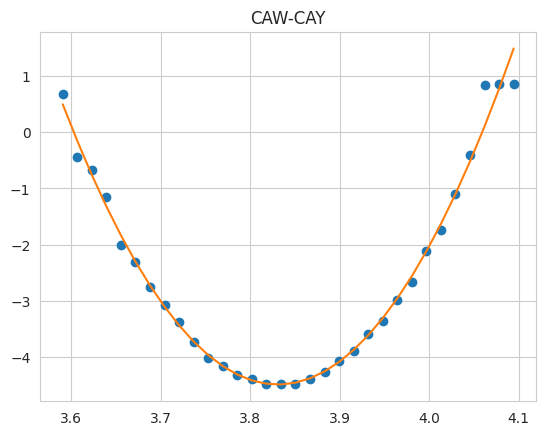

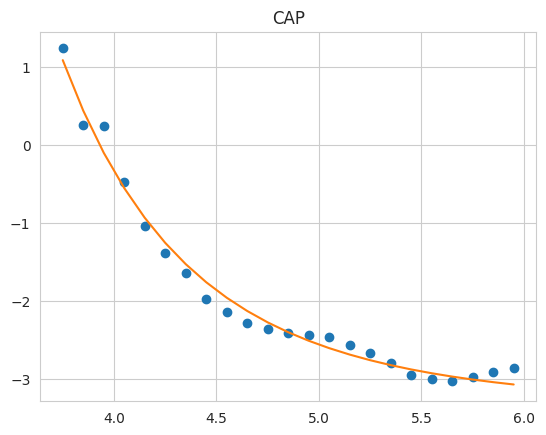

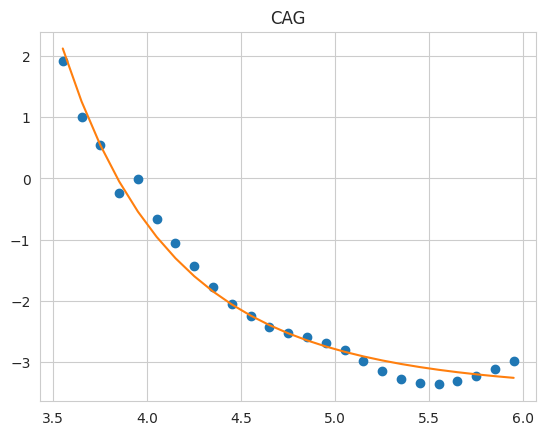

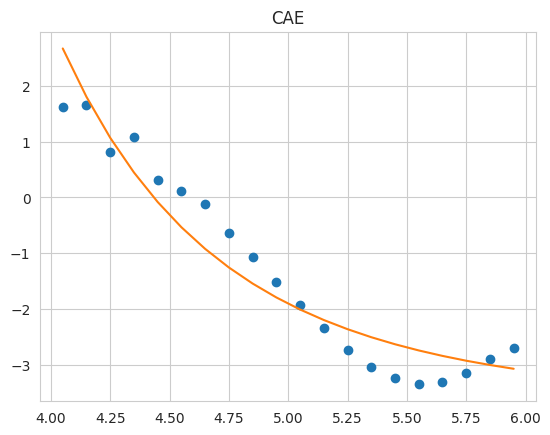

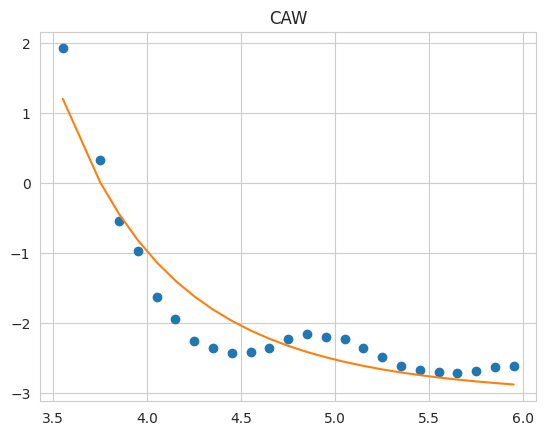

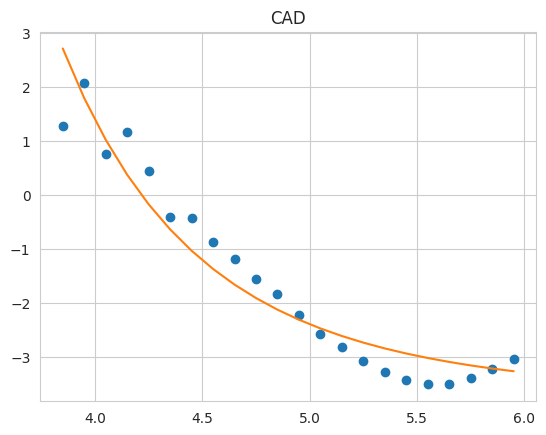

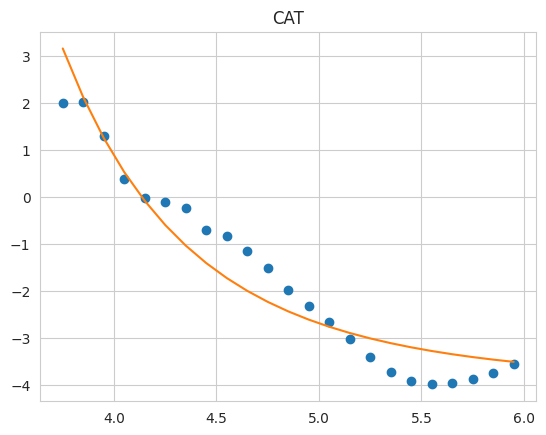

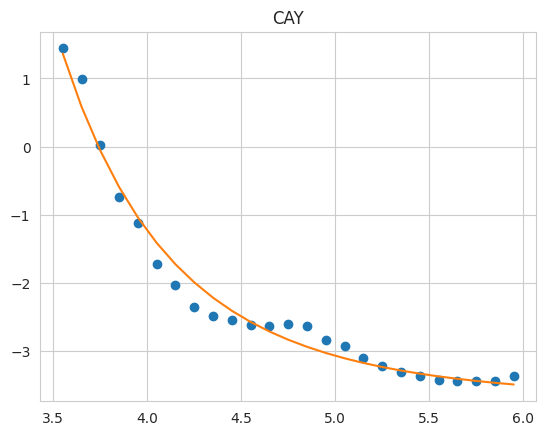

In [3]:
tt.fit_bonded_params(temperature=350, fit_range=[3.55, 4.2])
tt.fit_nonbonded_params(temperature=350, fit_range=[3, 6])

In [4]:
tt.write_forcefield(ff_file=os.path.join(training_data_folder, 'forcefield_priors.yaml'))

In [5]:
tt.calculate_deltaforces(
    forces=os.path.join(training_data_folder, 'chignolin_ca_forces.npy'), 
    forcefield=os.path.join(training_data_folder, 'forcefield_priors.yaml'),
    deltaforces=os.path.join(training_data_folder, 'chignolin_ca_deltaforces.npy'),
    )

Check for broken coords.


100%|██████████| 9/9 [00:00<00:00, 1134.28it/s]

No broken frames



/home/dpastor/Documents/programs/anaconda3/envs/nnpcg/lib/python3.9/site-packages/torchmd/systems.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.pos[:] = torch.tensor(
/home/dpastor/Documents/programs/anaconda3/envs/nnpcg/lib/python3.9/site-packages/torchmd/systems.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.box[r][torch.eye(3).bool()] = torch.tensor(


Producing delta forces


100%|██████████| 18689/18689 [00:15<00:00, 1185.52it/s]


In [6]:
AA2INT = {'ALA':1,
         'GLY':2,
         'PHE':3,
         'TYR':4,
         'ASP':5,
         'GLU':6,
         'TRP':7,
         'PRO':8,
         'ASN':9,
         'GLN':10,
         'HIS':11,
         'HSD':11,
         'HSE':11,
         'SER':12,
         'THR':13,
         'VAL':14,
         'MET':15,
         'CYS':16,
         'NLE':17,
         'ARG':18,
         'LYS':19,
         'LEU':20,
         'ILE':21
         }
tt.generate_embeddings(AA2INT, embedding_file=os.path.join(training_data_folder, 'chignolin_ca_embeddings.npy'))

In [7]:
tt.train_command()

Please run the following command in a terminal with the proper python env:
python train.py --conf train.yaml --log-dir data/train_light


In [8]:
# df = pd.read_csv('/home/dpastor/Dropbox (Biocomputing)/GitHub/projects/nnpcg/nnpcg/data/train_light/metrics.csv')

# fig, ax = plt.subplots(nrows = 2, figsize = [8,8])
# df.plot(x = 'epoch', y = ['train_loss', 'val_loss'], ax = ax[0])
# # ax[0].scatter([80], [df['val_loss'].loc[80]], s=200, c='r', marker=(5, 1), label='selected epoch')
# ax[0].set_ylabel('Loss')
# df.plot(x = 'epoch', y = 'lr', ax = ax[1])
# ax[1].set_ylabel('learning rate')